In [1]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-approval-prediction/credit_record.csv
/kaggle/input/credit-card-approval-prediction/application_record.csv


# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pd.set_option('max_colwidth', 100)


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
#from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import SVC
#from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

#from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

# Loading the data

In [3]:
credit_record_df = pd.read_csv("/kaggle/input/credit-card-approval-prediction/credit_record.csv")
application_record_df = pd.read_csv("/kaggle/input/credit-card-approval-prediction/application_record.csv")

# Exploring credit records

In [4]:
credit_record_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
credit_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


No missing data

In [6]:
print("Number of duplicated rows: ",sum(credit_record_df.duplicated()))

Number of duplicated rows:  0


No duplicated records

In [7]:
len(set(credit_record_df['MONTHS_BALANCE'])) #credit history stored up to 5 years (60 months)

61

In [8]:
print("Number of unique IDs: ",len(credit_record_df['ID'].unique())) #number of unique IDs

Number of unique IDs:  45985


We notice that # unique IDs are less than # rows.  
To explore why this is the case:

In [9]:
credit_record_df['ID'].value_counts()

5016769    61
5002806    61
5118192    61
5145767    61
5078567    61
           ..
5028795     1
5148442     1
5053900     1
5046332     1
5079047     1
Name: ID, Length: 45985, dtype: int64

In [10]:
credit_record_df[credit_record_df['ID']==5016769] #Taking ID 5016769 as an example

,ID,MONTHS_BALANCE,STATUS
183260,5016769,0,C
183261,5016769,-1,C
183262,5016769,-2,C
183263,5016769,-3,C
183264,5016769,-4,C
...,...,...,...
183316,5016769,-56,1
183317,5016769,-57,0
183318,5016769,-58,0
183319,5016769,-59,0


Some IDs have their status recorded across multiple months. So each ID-month pair identifies a unique instance

# Exploring application records

In [11]:
application_record_df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [12]:
application_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

Around 30% of the OCCUPATION_TYPE column is missing. So we might consider dropping the whole column

In [13]:
print("Number of duplicated rows: ", sum(application_record_df.duplicated()))

Number of duplicated rows:  0


No duplicate rows

In [14]:
application_record_df.shape

(438557, 18)

In [15]:
print("Number of unique IDs: ",len(application_record_df['ID'].unique()))

Number of unique IDs:  438510


We notice that # unique IDs < # rows.  

In [16]:
#examining the duplicate IDs
duplicated_ids = application_record_df[application_record_df['ID'].duplicated(keep='first')]['ID'].values
application_record_df[application_record_df['ID'].isin(duplicated_ids)].sort_values(by='ID').head(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
426488,7023108,F,N,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-17590,-1273,1,0,0,0,Cleaning staff,2.0
425306,7023651,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229,-1209,1,0,0,0,Accountants,1.0
421907,7023651,M,Y,N,1,157500.0,Commercial associate,Incomplete higher,Married,House / apartment,-10521,-1457,1,0,0,0,Drivers,3.0
427778,7024111,M,N,N,2,157500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15270,-117,1,1,0,0,Drivers,4.0
432643,7024111,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-22041,-1524,1,1,1,0,Accountants,2.0


Since the duplicates have different information (family size, gender, number of children,...) they will be omitted from the dataset

In [17]:
application_record_df[application_record_df['DAYS_BIRTH']==-15272].head(15)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
97417,5403669,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,Core staff,2.0
97418,5403674,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,Core staff,2.0
97419,5403675,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,Core staff,2.0
97420,6154303,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,Core staff,2.0
106692,5452063,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0
106693,5452064,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0
106694,5452065,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0
106695,5452066,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0
106696,5452067,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0
106697,5452068,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,Drivers,3.0


Some instances have different IDs but same information. Since we do not use IDs when training a ML model, these rows will be duplicates.  
So we need to drop them.

### Exploring Categorical variables

In [18]:
categorical_feats = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL']


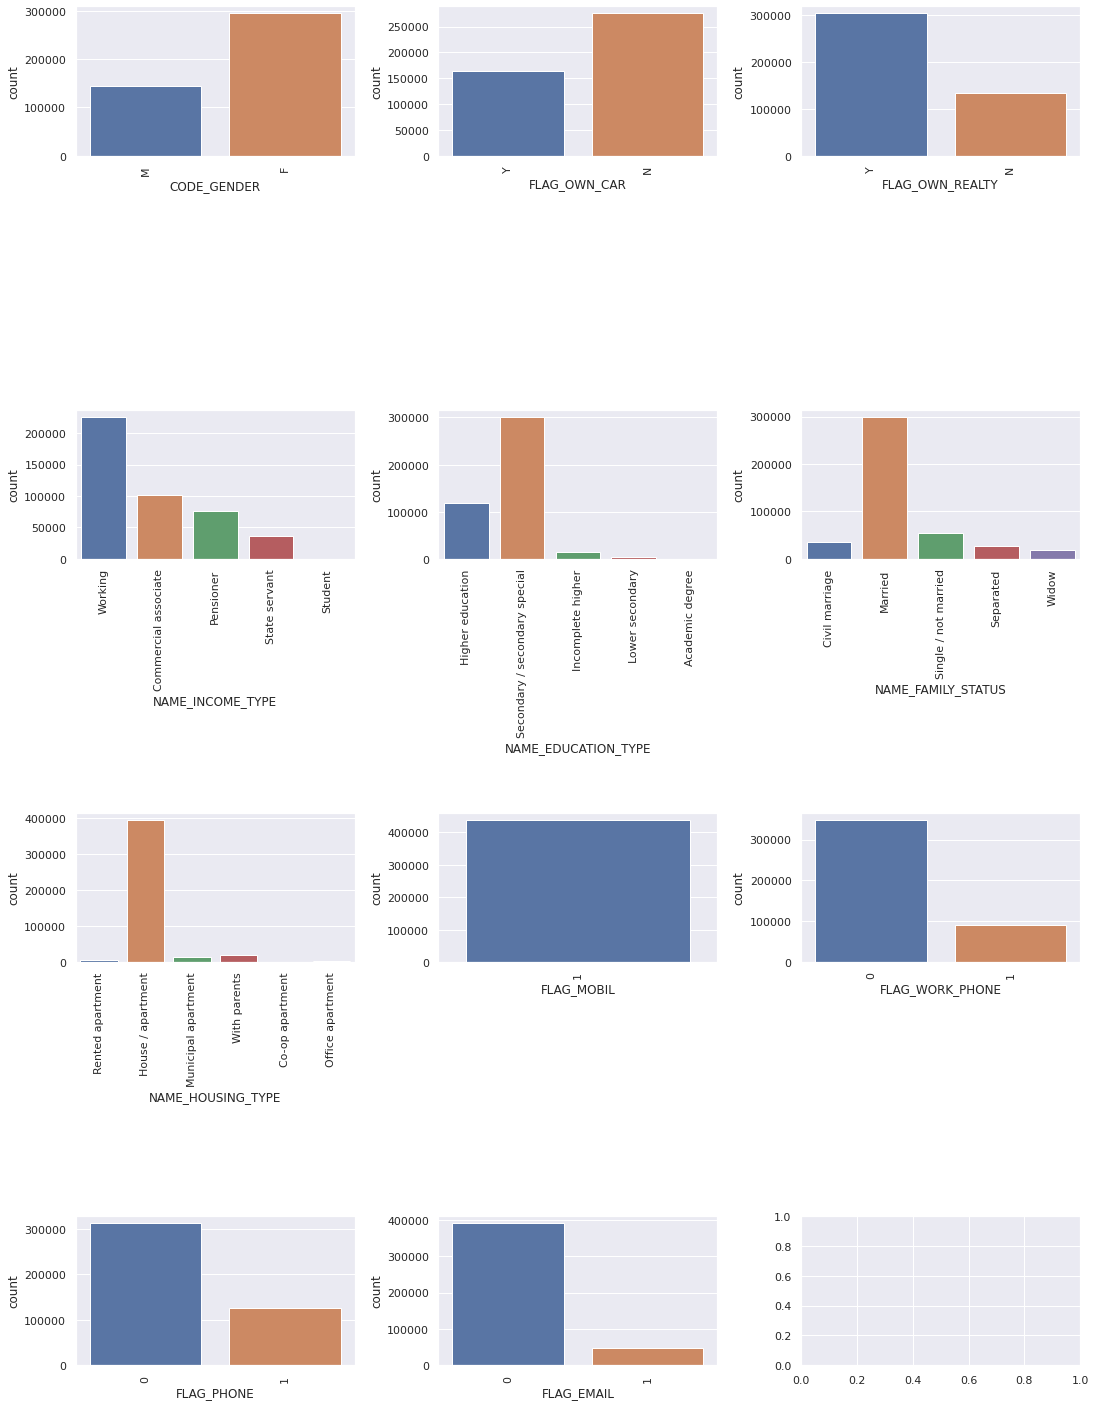

In [19]:
figure, axes = plt.subplots(4,3, figsize=(18,25))
axes_flatteled = axes.flatten()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.7)


for idx, feat in enumerate(categorical_feats):
    sns.countplot(ax=axes_flatteled[idx], data=application_record_df, x=feat)
    axes_flatteled[idx].set_xticklabels(axes_flatteled[idx].get_xticklabels(), rotation =90)


The feature FLAG_MOBILE has only one unique value, so it has to be dropped.  
The feature NAME_HOUSING_TYPE is very dominated by a single category, so it is very unlikely to provide useful information. It will be dropped.  
In feature NAME_INCOME_TYPE, the category 'Student' has very few observations. And it would be better if we omitted this feature since the feature AMT_INCOME_TOTAL is what makes a difference. The same goes for NAME_EDUCATION_TYPE

### Exploring Numerical Variables

In [20]:
numerical_feats = ['DAYS_BIRTH','DAYS_EMPLOYED','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']

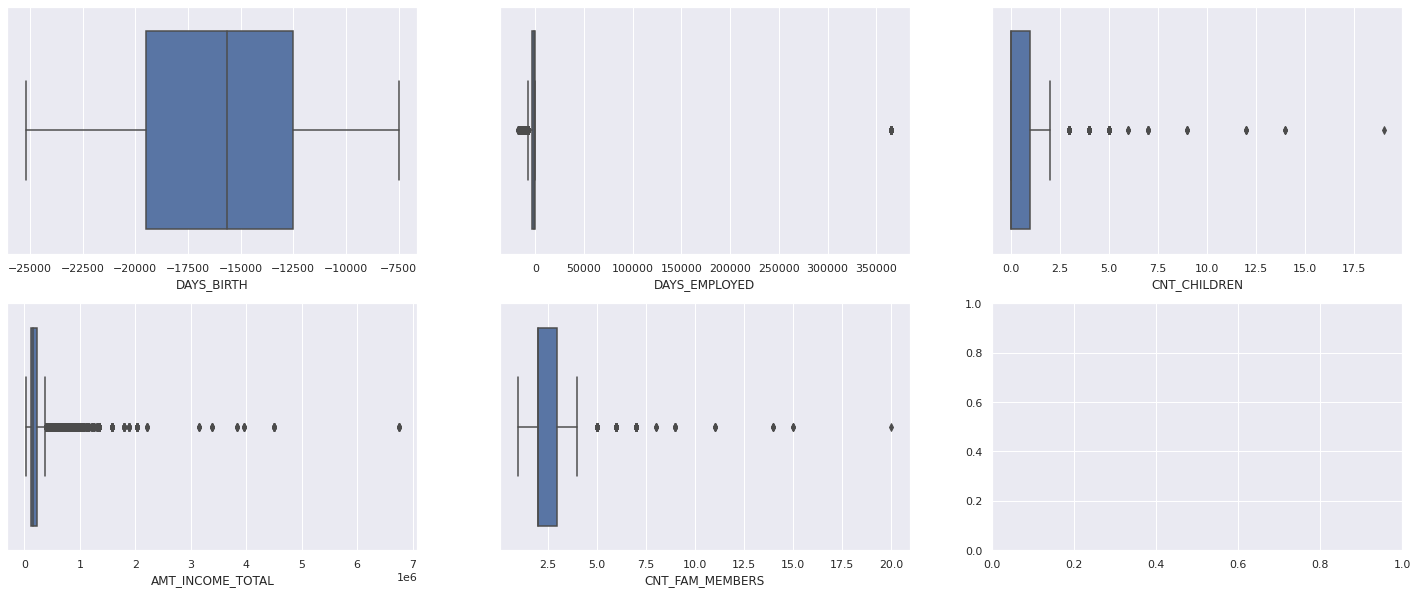

In [21]:
figure, axes = plt.subplots(2,3, figsize=(25,10))
axes_flatteled = axes.flatten()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.7)


for idx, feat in enumerate(numerical_feats):
    sns.boxplot(ax=axes_flatteled[idx], data=application_record_df, x=feat)
    #axes_flatteled[idx].set_xticklabels(axes_flatteled[idx].get_xticklabels(), rotation =90)


In [22]:
application_record_df[numerical_feats].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,CNT_CHILDREN,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS
count,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000
mean,-15997.904649,60563.675328,0.427390,1.875243e+05,2.194465
std,4185.030007,138767.799647,0.724882,1.100869e+05,0.897207
min,-25201.000000,-17531.000000,0.000000,2.610000e+04,1.000000
25%,-19483.000000,-3103.000000,0.000000,1.215000e+05,2.000000
50%,-15630.000000,-1467.000000,0.000000,1.607805e+05,2.000000
75%,-12514.000000,-371.000000,1.000000,2.250000e+05,3.000000
max,-7489.000000,365243.000000,19.000000,6.750000e+06,20.000000


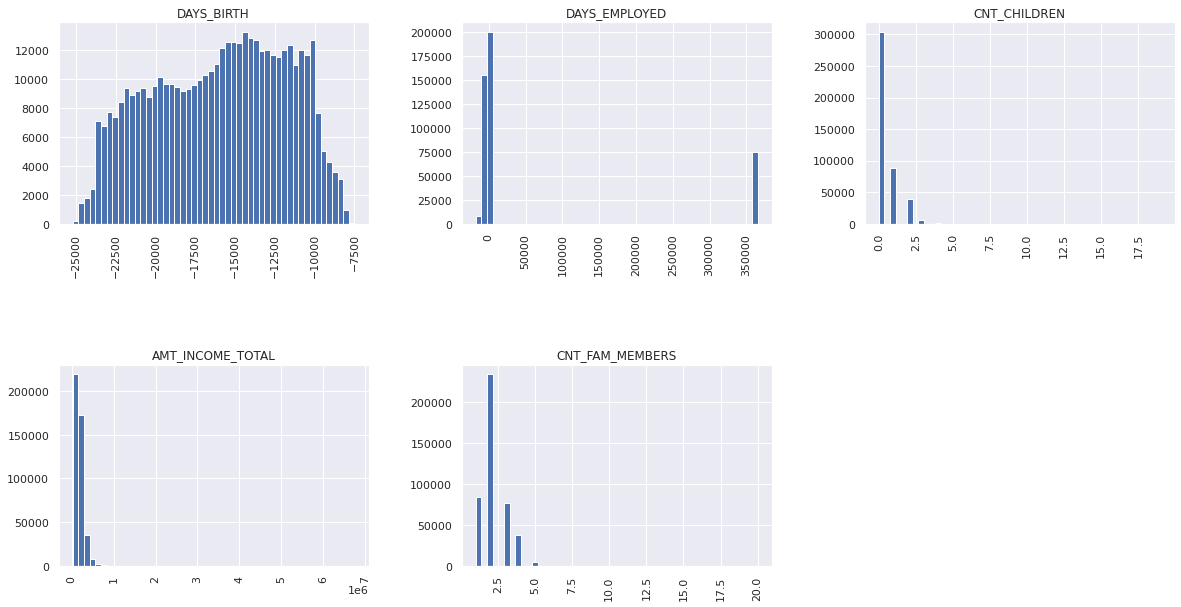

In [23]:
application_record_df[numerical_feats].hist(layout=(2,3), figsize=(20,10),bins=50, xrot=90)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

plt.show()

The numerical features need to be scaled (standardized/ Normalized).  
To avoid the efect of outliers, we can use an ML model that is robust against outliers (i.e. Random Forest).  
The outliers in DAYS_EMPLOYED (value = 365243) are not actual days, but an indication that the client is unemployed

#### From the Previous EDA, We need to preprocess the data in the following steps:
- Remove OCCUPATION_TYPE. FLAG_MOBILE, NAME_HOUSING_TYPE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE columns from application records
- Remove the rows containing duplicate IDs from application records.
- Remove the rows that contain duplicate information with different IDs in application records
- Encode categorical variables
- Convert birthdays to years (difference in few months or days should not have an effect)
- Convert DAYS_EMPLOYED to +ve numbers (in months, rounded up), with 0 meaning unemployed

##### Some of these steps must be applied at test time


# Constructing Labels

**The codes in the STATUS column indicate the following:**  
0: 1-29 days past due  
1: 30-59 days past due  
2: 60-89 days overdue  
3: 90-119 days overdue  
4: 120-149 days overdue  
5: Overdue or bad debts, write-offs for more than 150 days  
C: paid off that month  
X: No loan for the month  
  
  
- If a client got STATUS= 4 or 5 (past due by more than 4 months), they will be labelled as bad clients  

Otherwise, we judge based on the # months the client failed to pay by the due date, compared by the # months he didn't:  
- If $ \frac{no.~months~STATUS==0}{no.~months~STATUS==X~or~C}>=1$, the client will be labelled as a bad client
- If $ \frac{no.~months~STATUS==1}{0.75*no.~months~STATUS==X~or~C}>=1$, the client will be labelled as a bad client
- If $ \frac{no.~months~STATUS==2}{0.5*no.~months~STATUS==X~or~C}>=1$, the client will be labelled as a bad client
- If $ \frac{no.~months~STATUS==3}{0.25*no.~months~STATUS==X~or~C}>=1$, the client will be labelled as a bad client

In [24]:
status_ratio_df = pd.DataFrame(credit_record_df.groupby(['ID', 'STATUS'])['STATUS'].count())\
                                .rename(columns={'STATUS': 'STATUS_count'})\
                                .reset_index()
status_ratio_df

,ID,STATUS,STATUS_count
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [25]:
conditions = [status_ratio_df['STATUS']=='X', status_ratio_df['STATUS']=='C']
choices = [status_ratio_df['STATUS_count'], status_ratio_df['STATUS_count']]
status_ratio_df['X_or_C'] = np.select(conditions, choices, default=0)
status_ratio_df

,ID,STATUS,STATUS_count,X_or_C
0,5001711,0,3,0
1,5001711,X,1,1
2,5001712,0,10,0
3,5001712,C,9,9
4,5001713,X,22,22
...,...,...,...,...
94138,5150483,X,18,18
94139,5150484,0,12,0
94140,5150484,C,1,1
94141,5150485,0,2,0


In [26]:
temp_df = pd.DataFrame(status_ratio_df.groupby('ID')['X_or_C'].sum()).rename(columns={'X_or_C':'X_or_C_count'}).reset_index()
temp_df.head()

,ID,X_or_C_count
0,5001711,1
1,5001712,9
2,5001713,22
3,5001714,15
4,5001715,60


In [27]:
status_ratio_df = status_ratio_df.merge(temp_df, on='ID', how='left').drop(columns='X_or_C')
status_ratio_df.head(10)

,ID,STATUS,STATUS_count,X_or_C_count
0,5001711,0,3,1
1,5001711,X,1,1
2,5001712,0,10,9
3,5001712,C,9,9
4,5001713,X,22,22
5,5001714,X,15,15
6,5001715,X,60,60
7,5001717,0,17,5
8,5001717,C,5,5
9,5001718,0,24,13


In [28]:
conditions = [(status_ratio_df['STATUS']=='0')&((status_ratio_df['STATUS_count']/status_ratio_df['X_or_C_count'])>=1),
              (status_ratio_df['STATUS']=='1')&((status_ratio_df['STATUS_count']/(0.75*status_ratio_df['X_or_C_count']))>=1),
              (status_ratio_df['STATUS']=='2')&((status_ratio_df['STATUS_count']/(0.5*status_ratio_df['X_or_C_count']))>=1), 
              (status_ratio_df['STATUS']=='3')&((status_ratio_df['STATUS_count']/(0.25*status_ratio_df['X_or_C_count']))>=1),
              status_ratio_df['STATUS']=='4', status_ratio_df['STATUS']=='5',
              status_ratio_df['STATUS']=='X', status_ratio_df['STATUS']=='C']
choices = [1,1,1,1,1,1,0,0]

status_ratio_df['bad_client_temp'] = np.select(conditions, choices, default=0)
status_ratio_df

,ID,STATUS,STATUS_count,X_or_C_count,bad_client_temp
0,5001711,0,3,1,1
1,5001711,X,1,1,0
2,5001712,0,10,9,1
3,5001712,C,9,9,0
4,5001713,X,22,22,0
...,...,...,...,...,...
94138,5150483,X,18,18,0
94139,5150484,0,12,1,1
94140,5150484,C,1,1,0
94141,5150485,0,2,0,1


In [29]:
targets_df = pd.DataFrame(status_ratio_df.groupby('ID')['bad_client_temp'].max()).rename(columns={'bad_client_temp':'bad_client'}).reset_index()
targets_df

,ID,bad_client
0,5001711,1
1,5001712,1
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,1
45981,5150483,0
45982,5150484,1
45983,5150485,1


### Add the labels to corresponding applicants information

In [30]:
final_df = application_record_df.merge(targets_df, on='ID', how='left')
final_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad_client
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438557 entries, 0 to 438556
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

**Since some applicants didn't have their history informations, and hence have no labels, they will be dropped**

In [32]:
final_df.dropna(subset=['bad_client'], inplace=True)

In [33]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 434812
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null

# Initial Preprocessing
Preprocessing that must be done befor even splitting the data:  

- Remove the rows containing duplicate IDs.
- Remove the rows that contain duplicate information with different IDs


In [34]:
print('Number of rows containing same ID: ',sum(final_df.duplicated(subset='ID')))
print('Number of rows containing duplicated information: ',sum(final_df.drop(columns='ID').duplicated()))

Number of rows containing same ID:  0
Number of rows containing duplicated information:  22797


In [35]:
final_df.drop_duplicates(subset=list(set(final_df.columns) - {'ID'}), inplace=True)

In [36]:
final_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad_client
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,1.0
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434797,5148694,F,N,N,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,-20600,-198,1,0,0,0,Laborers,2.0,1.0
434801,5149055,F,N,Y,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15837,-2694,1,1,1,0,NaN,2.0,0.0
434806,5149729,M,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1,0,0,0,NaN,2.0,1.0
434810,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,1.0


# Before strarting further preprocessing, we need to hold out a test split so that we take unbiased decisions

In [37]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['ID', 'bad_client'],axis=1), final_df['bad_client'], test_size=0.2, random_state=0, stratify=final_df['bad_client'])

# More Preprocessing
Preprocessing steps that requires manipulating the data, where decisions need to be made based on training data only to avoid data leakage.  
Also contains preprocessing steps that need to be applied at test time
  
  
- Remove OCCUPATION_TYPE. FLAG_MOBILE, NAME_HOUSING_TYPE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE columns
- Encode categorical variables
- Convert birthdays to years (difference in few months or days should not have an effect)
- Convert DAYS_EMPLOYED to +ve numbers (in months, rounded up), with 0 meaning unemployed

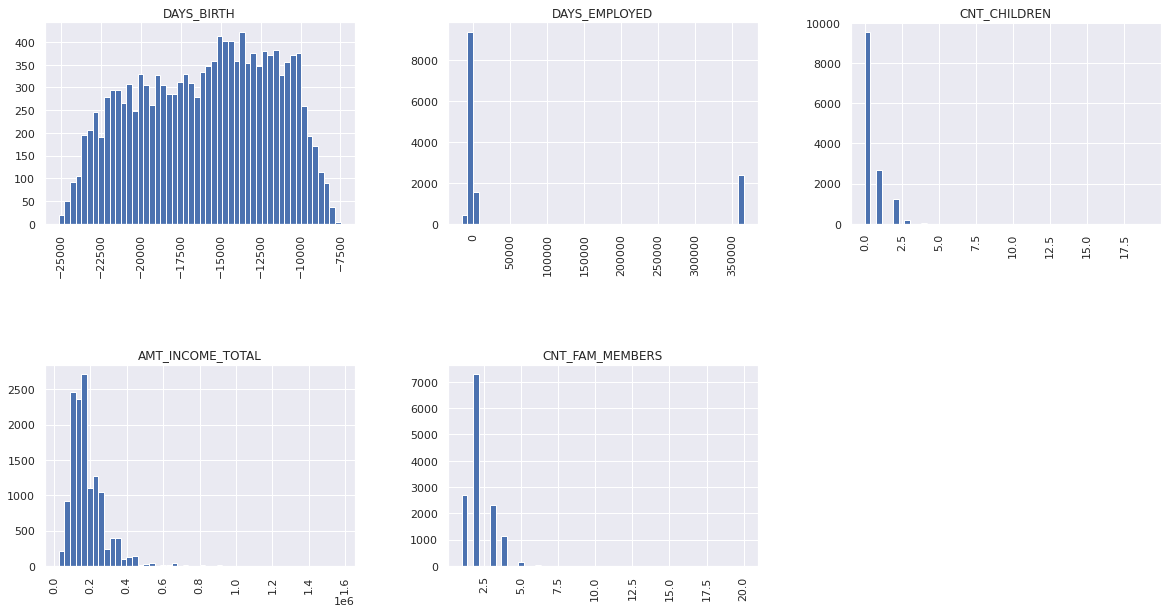

In [38]:
final_df[numerical_feats].hist(layout=(2,3), figsize=(20,10),bins=50, xrot=90)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

plt.show()

### 1- Removing unnecessary columns

In [39]:
#Defining a transformer that remove unnecessary columns
def drop_cols(df,cols_to_drop):
    #cols_to_drop = ['OCCUPATION_TYPE', 'FLAG_MOBIL', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']
    df_copy = df.copy()
    
    ret_df = df_copy.drop(columns=cols_to_drop)
    return ret_df

cols_to_drop = ['OCCUPATION_TYPE', 'FLAG_MOBIL', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']

drop_cols_trans = FunctionTransformer(drop_cols, kw_args={'cols_to_drop':cols_to_drop})


### 2- Encoding categorical features

In [40]:
categorical_feats = ['CODE_GENDER', 'NAME_FAMILY_STATUS','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [41]:
for feat in categorical_feats:
    print('Unique values for {}:\t\t{}'.format(feat, X_train[feat].unique()))

Unique values for CODE_GENDER:		['M' 'F']
Unique values for NAME_FAMILY_STATUS:		['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']
Unique values for FLAG_OWN_CAR:		['Y' 'N']
Unique values for FLAG_OWN_REALTY:		['N' 'Y']


**The features are not of high cardinality, so one-hot encoding will be suitable**

In [42]:
#One-hot encoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

### 3- Convert DAYS_BIRTH and DAYS_EMPLOYED

In [43]:
# Defining a transformer to convert DAYS_BIRTH to years, and DAYS_EMPLOYED to months
def convert_days(df):
    df_copy = df.copy()
    #df_copy['YEARS_BIRTH']=((df_copy['DAYS_BIRTH']/365.0)*-1).astype(float).round().astype(int)
    df_copy['YEARS_BIRTH'] = np.ceil((df_copy['DAYS_BIRTH']/365.0)*-1).astype(int)
    
    df_copy['MONTHS_EMPLOYED'] = np.ceil((df_copy['DAYS_EMPLOYED']/30.0)*-1).astype(int)
    df_copy['MONTHS_EMPLOYED'] = np.select(condlist=[df_copy['MONTHS_EMPLOYED']>0], choicelist=[df_copy['MONTHS_EMPLOYED']], default=0)
    
    df_copy.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'], inplace=True)
    return df_copy

convert_days_trans = FunctionTransformer(convert_days)


In [44]:
# temp_df = convert_days_trans.fit_transform(X_train)

### 4- Normalizing numerical features
min-max normalization will be used to make the numerical features in the same 0-1 range as the encoded categorical features

In [45]:
numerical_feats = ['YEARS_BIRTH','MONTHS_EMPLOYED','CNT_CHILDREN','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS']
numerical_normalizer = MinMaxScaler()

In [46]:
X_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

# Model

In [47]:
rf_clf = RandomForestClassifier(n_estimators=15 ,max_depth=2, random_state=0, n_jobs=-1)

In [48]:
knn_clf = KNeighborsClassifier(n_neighbors=95, weights='uniform', metric='euclidean')

# Constructing the pipeline

In [49]:
preprocessor = ColumnTransformer(transformers=[
    #("drop_cols", drop_cols_trans, X_train.columns),
    #("drop_cols", 'drop', cols_to_drop),
    #("convert_days", convert_days_trans, X_train.columns),
    ('normalizer', numerical_normalizer, numerical_feats),
    ("encoder", categorical_transformer, categorical_feats)], remainder='passthrough')

In [50]:
pipeline = Pipeline(steps=[
    ("drop_cols", drop_cols_trans),
    ("convert_days", convert_days_trans),
    ("preprocessor", preprocessor),
    ("model", rf_clf)
], verbose=False)



In [51]:
scoring = {'acc': 'accuracy',
           'f1': 'f1_weighted'}

cv_score= cross_validate(pipeline, X_train, y_train, scoring=scoring,cv=5)

print('Cross-validation accuracy',cv_score['test_acc'].mean())
pipeline.fit(X_train, y_train)
print('Accuracy on training set',pipeline.score(X_train, y_train))

print('\n\nCross-validation F1 score',cv_score['test_f1'].mean())

pred_trainSet = pipeline.predict(X_train)
print('F1 score on training set', f1_score(y_train, pred_trainSet, average='weighted'))

Cross-validation accuracy 0.5013724952422426
Accuracy on training set 0.5167459736456809


Cross-validation F1 score 0.4975310829418268
F1 score on training set 0.5147377479150752


In [52]:
pipelines = {'rf_pipeline': pipeline}

In [53]:
pipelines['rf_pipeline'].fit(X_train, y_train)

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_cols at 0x7f497a35a050>,
                                     kw_args={'cols_to_drop': ['OCCUPATION_TYPE',
                                                               'FLAG_MOBIL',
                                                               'NAME_HOUSING_TYPE',
                                                               'NAME_INCOME_TYPE',
                                                               'NAME_EDUCATION_TYPE']})),
                ('convert_days',
                 FunctionTransformer(func=<function convert_days at 0x7f497a3a65f0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalizer', MinMaxScaler(),
                                                  ['YEARS_BIRTH',
                                                   'MONTHS_EMPLOYED',
                                           

In [54]:
#Hyperparameters tuning
params = {'model__n_estimators': [5,10,15,20,25],
         'model__max_depth': [2,3,4,5,6,7]}


randomSearch = RandomizedSearchCV(pipeline, params, n_iter=10, scoring='f1_weighted',
                                  cv=5,random_state=0, verbose=1, n_jobs=-1)

randomSearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.8s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('drop_cols',
                                              FunctionTransformer(func=<function drop_cols at 0x7f497a35a050>,
                                                                  kw_args={'cols_to_drop': ['OCCUPATION_TYPE',
                                                                                            'FLAG_MOBIL',
                                                                                            'NAME_HOUSING_TYPE',
                                                                                            'NAME_INCOME_TYPE',
                                                                                            'NAME_EDUCATION_TYPE']})),
                                             ('convert_days',
                                              FunctionTransformer(func=<function convert_days at 0x7f497a3a65f0>)),
                                             ('preprocessor',
    

In [55]:
pd.DataFrame(randomSearch.cv_results_).drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time',
                                             'param_model__n_estimators','param_model__max_depth'], axis=1).sort_values('rank_test_score')


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'model__n_estimators': 15, 'model__max_depth': 2}",0.495204,0.505469,0.495828,0.497724,0.493431,0.497531,0.004200,1
3,"{'model__n_estimators': 5, 'model__max_depth': 4}",0.476272,0.494002,0.496438,0.488932,0.496722,0.490473,0.007631,2
7,"{'model__n_estimators': 10, 'model__max_depth': 4}",0.480008,0.500703,0.493629,0.479583,0.497327,0.490250,0.008826,3
2,"{'model__n_estimators': 20, 'model__max_depth': 4}",0.486378,0.505781,0.484545,0.481382,0.490981,0.489813,0.008567,4
8,"{'model__n_estimators': 15, 'model__max_depth': 5}",0.491528,0.490615,0.470737,0.482432,0.476677,0.482398,0.007995,5
9,"{'model__n_estimators': 15, 'model__max_depth': 6}",0.468778,0.470717,0.463217,0.480939,0.459251,0.468581,0.007391,6
5,"{'model__n_estimators': 25, 'model__max_depth': 6}",0.454005,0.470587,0.458597,0.474566,0.468352,0.465221,0.007689,7
4,"{'model__n_estimators': 10, 'model__max_depth': 7}",0.469902,0.471545,0.459403,0.439376,0.467360,0.461517,0.011830,8
1,"{'model__n_estimators': 20, 'model__max_depth': 7}",0.465177,0.461126,0.457545,0.442042,0.450774,0.455333,0.008158,9
6,"{'model__n_estimators': 15, 'model__max_depth': 7}",0.467495,0.461465,0.454265,0.437842,0.446206,0.453455,0.010567,10


#### KNN classifier

In [56]:
pipeline = Pipeline(steps=[
    ("drop_cols", drop_cols_trans),
    ("convert_days", convert_days_trans),
    ("preprocessor", preprocessor),
    ("model", knn_clf)
], verbose=False)

In [57]:
scoring = {'acc': 'accuracy',
           'f1': 'f1_weighted'}

cv_score= cross_validate(pipeline, X_train, y_train, scoring=scoring,cv=5)

print('Cross-validation accuracy',cv_score['test_acc'].mean())
pipeline.fit(X_train, y_train)
print('Accuracy on training set',pipeline.score(X_train, y_train))

print('\n\nCross-validation F1 score',cv_score['test_f1'].mean())

pred_trainSet = pipeline.predict(X_train)
print('F1 score on training set', f1_score(y_train, pred_trainSet, average='weighted'))

Cross-validation accuracy 0.4895682740803239
Accuracy on training set 0.5315702781844802


Cross-validation F1 score 0.48951629590778023
F1 score on training set 0.5315470361510124


In [58]:
pipelines['knn_pipeline'] = pipeline

In [59]:
pipelines['knn_pipeline'].fit(X_train, y_train)

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_cols at 0x7f497a35a050>,
                                     kw_args={'cols_to_drop': ['OCCUPATION_TYPE',
                                                               'FLAG_MOBIL',
                                                               'NAME_HOUSING_TYPE',
                                                               'NAME_INCOME_TYPE',
                                                               'NAME_EDUCATION_TYPE']})),
                ('convert_days',
                 FunctionTransformer(func=<function convert_days at 0x7f497a3a65f0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('normalizer', MinMaxScaler(),
                                                  ['YEARS_BIRTH',
                                                   'MONTHS_EMPLOYED',
                                           

In [60]:
#Hyperparameters tuning
params = {'model__n_neighbors': [56,58,60,65,70,75,80,85,90,95,100,105,110],
          'model__weights':['uniform', 'distance'],
         'model__metric': ['chebyshev', 'euclidean','manhattan', 'hamming','canberra','braycurtis']}


randomSearch = RandomizedSearchCV(pipeline, params, n_iter=40, scoring='f1_weighted',
                                  cv=5,random_state=0, verbose=1, n_jobs=-1)

randomSearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('drop_cols',
                                              FunctionTransformer(func=<function drop_cols at 0x7f497a35a050>,
                                                                  kw_args={'cols_to_drop': ['OCCUPATION_TYPE',
                                                                                            'FLAG_MOBIL',
                                                                                            'NAME_HOUSING_TYPE',
                                                                                            'NAME_INCOME_TYPE',
                                                                                            'NAME_EDUCATION_TYPE']})),
                                             ('convert_days',
                                              FunctionTransformer(func=<function convert_days at 0x7f497a3a65f0>)),
                                             ('preprocessor',
    

In [61]:
pd.DataFrame(randomSearch.cv_results_).drop(['mean_fit_time','std_fit_time','mean_score_time','std_score_time',
                                             'param_model__n_neighbors','param_model__weights','param_model__metric'], axis=1)\
                                    .sort_values('rank_test_score').head(10)


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,"{'model__weights': 'uniform', 'model__n_neighbors': 95, 'model__metric': 'euclidean'}",0.488461,0.489018,0.489016,0.482363,0.498724,0.489516,0.005245,1
9,"{'model__weights': 'uniform', 'model__n_neighbors': 85, 'model__metric': 'euclidean'}",0.492185,0.477103,0.486672,0.482350,0.501005,0.487863,0.008234,2
25,"{'model__weights': 'uniform', 'model__n_neighbors': 105, 'model__metric': 'braycurtis'}",0.489765,0.480739,0.478039,0.481002,0.496070,0.485123,0.006749,3
4,"{'model__weights': 'uniform', 'model__n_neighbors': 110, 'model__metric': 'chebyshev'}",0.480916,0.486996,0.474804,0.486846,0.495583,0.485029,0.006929,4
30,"{'model__weights': 'uniform', 'model__n_neighbors': 90, 'model__metric': 'chebyshev'}",0.477339,0.487359,0.487437,0.485684,0.485783,0.484721,0.003765,5
12,"{'model__weights': 'uniform', 'model__n_neighbors': 60, 'model__metric': 'canberra'}",0.475893,0.487315,0.482413,0.475082,0.501000,0.484340,0.009457,6
27,"{'model__weights': 'uniform', 'model__n_neighbors': 75, 'model__metric': 'manhattan'}",0.491751,0.480787,0.473465,0.480499,0.495193,0.484339,0.007979,7
21,"{'model__weights': 'uniform', 'model__n_neighbors': 70, 'model__metric': 'chebyshev'}",0.481433,0.482585,0.482837,0.469897,0.499272,0.483205,0.009369,8
34,"{'model__weights': 'uniform', 'model__n_neighbors': 105, 'model__metric': 'chebyshev'}",0.481177,0.480267,0.468414,0.487373,0.495684,0.482583,0.008974,9
0,"{'model__weights': 'uniform', 'model__n_neighbors': 56, 'model__metric': 'euclidean'}",0.475440,0.478862,0.485781,0.479572,0.492893,0.482509,0.006172,10


# Testing on the test set

In [62]:
#random forest classifier
pred_rf = pipelines['rf_pipeline'].predict(X_test)
print('Accuracy on test set',pipeline.score(X_test, y_test))
print('F1 score on test set', f1_score(y_test, pred_rf, average='weighted'))

Accuracy on test set 0.46010248901903367
F1 score on test set 0.487776697393859


In [63]:
#KNN classifier
pred_knn = pipelines['knn_pipeline'].predict(X_test)
print('Accuracy on test set',pipeline.score(X_test, y_test))
print('F1 score on test set', f1_score(y_test, pred_knn, average='weighted'))

Accuracy on test set 0.46010248901903367
F1 score on test set 0.4599924446916723


#### When looking at the data, the features do not provide separation between the classes, hence the bad results of the classifiers

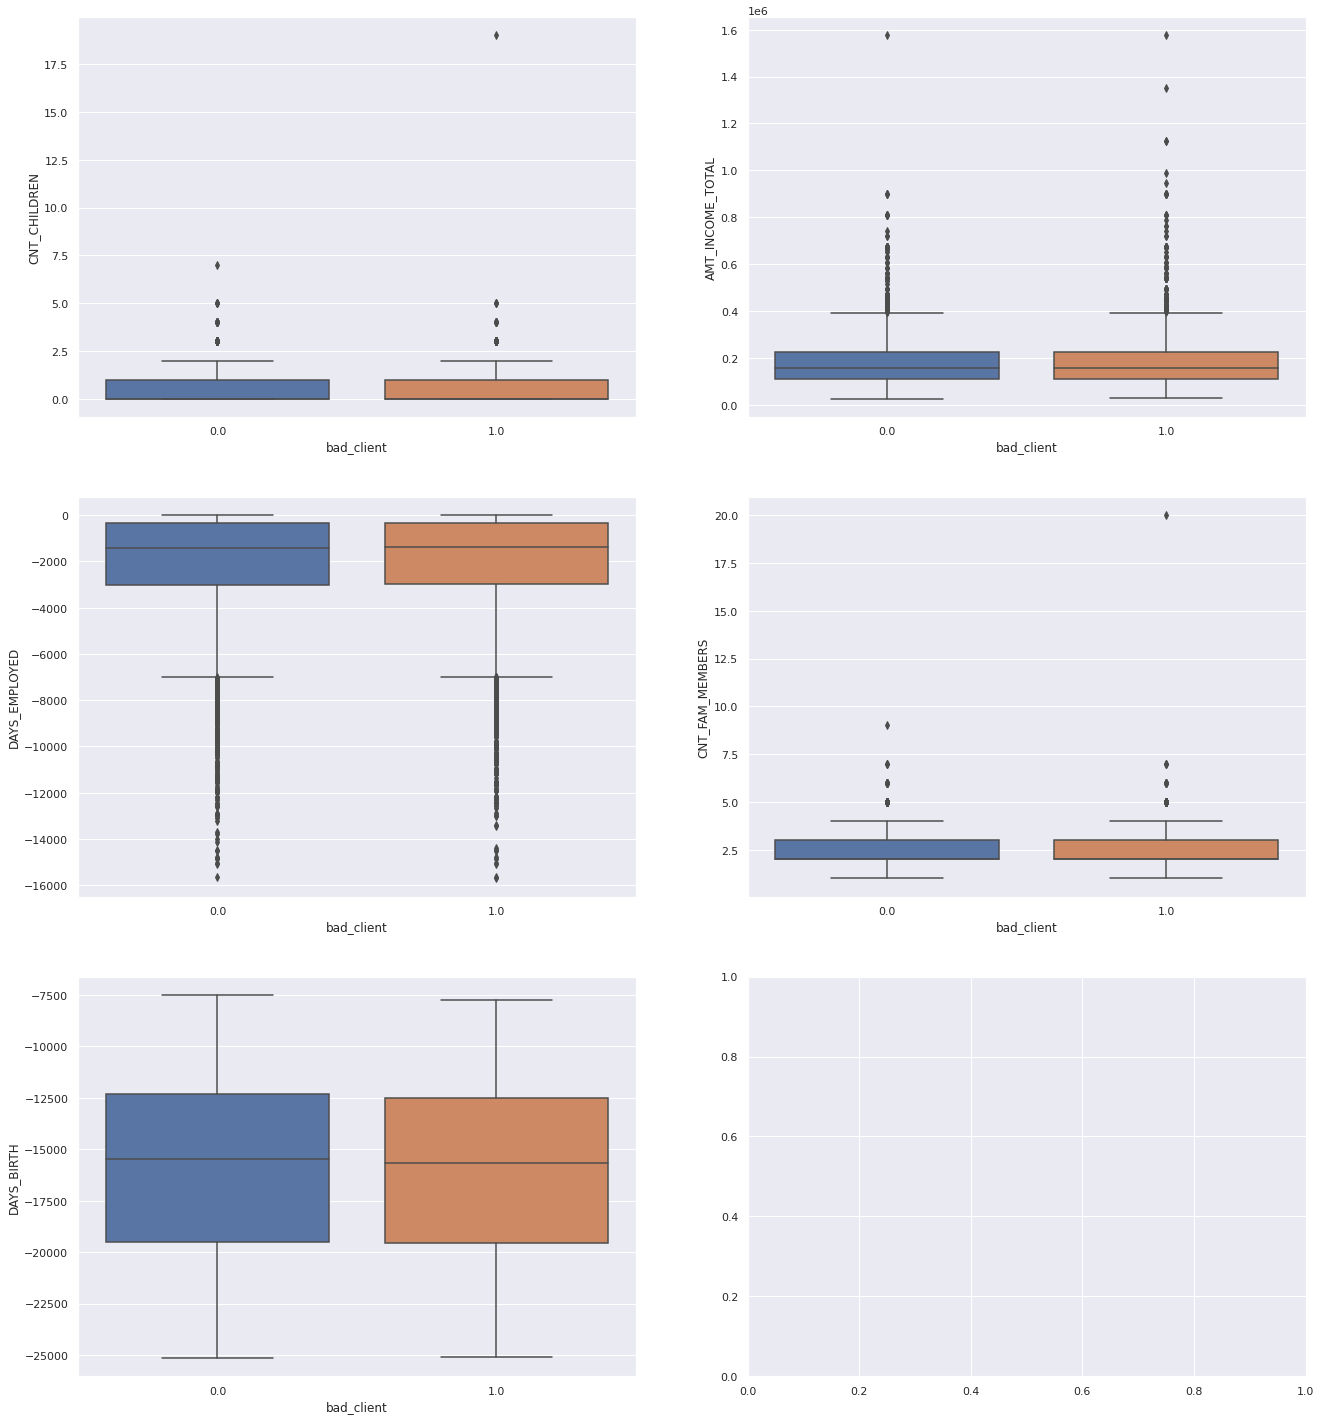

In [64]:
temp_train = X_train
temp_train['bad_client'] = y_train
temp_train['DAYS_EMPLOYED'] = np.select(condlist=[temp_train['DAYS_EMPLOYED']<0], choicelist=[temp_train['DAYS_EMPLOYED']], default=0)

names = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_EMPLOYED','CNT_FAM_MEMBERS', 'DAYS_BIRTH']
fig, axes = plt.subplots(3,2, figsize=(22,25))

for i,t in enumerate(names):
    ax = sns.boxplot(y=t, x='bad_client', data=temp_train, orient='v', ax=axes.flatten()[i] )


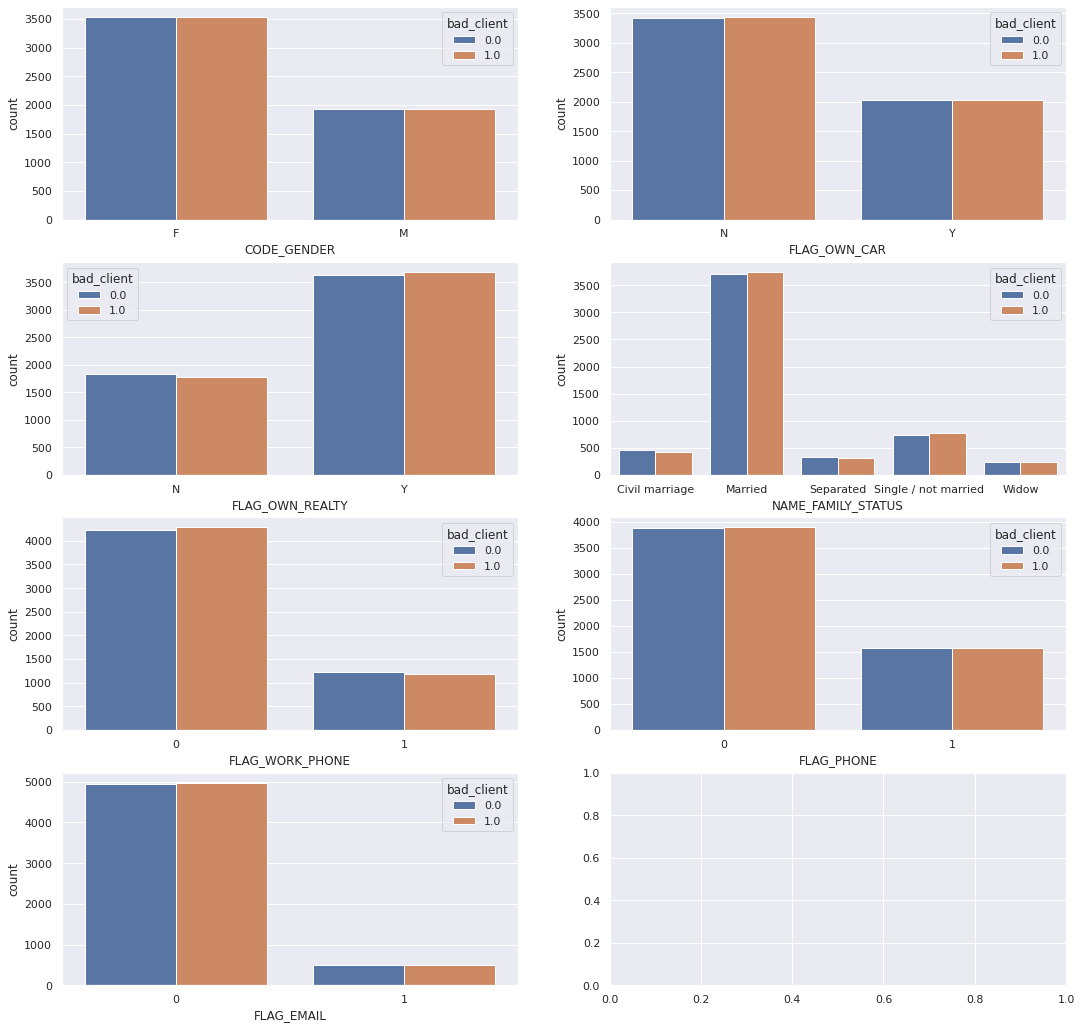

In [65]:
categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                    'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

figure, axes = plt.subplots(4,2, figsize=(18,18))
axes_flatteled = axes.flatten()


for idx, col in enumerate(categorical_cols):
    df = pd.DataFrame(temp_train.groupby([col,'bad_client'])[col].count())\
            .rename(columns={col:'count'}).reset_index()
    sns.barplot(ax=axes_flatteled[idx], x=col, y="count", hue="bad_client", data=df)